# Address Matching Deep Dive

This notebook experiments with different ways of comparing addresses in order to demonstrate the power of parsed address comparison.

In [200]:
import json
import logging
import os
import re
import sys
import time
import warnings
from numbers import Number
from typing import Callable, Dict, List, Literal, Sequence, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import pyarrow.dataset as ds
import pycountry
import pytest
import random
import seaborn as sns
import torch
import torch.nn as nn
import wandb
from datasets import Dataset
from fuzzywuzzy import fuzz

from postal.parser import parse_address
from scipy.spatial import distance
from sklearn.metrics import (
    accuracy_score,
    precision_recall_curve,
    precision_recall_fscore_support,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    auc
)
from sklearn.model_selection import train_test_split
from sentence_transformers import InputExample, SentenceTransformer, SentencesDataset, SentenceTransformerTrainer, losses
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator, SimilarityFunction, BinaryClassificationEvaluator
from sentence_transformers.model_card import SentenceTransformerModelCardData
from sentence_transformers.training_args import BatchSamplers, SentenceTransformerTrainingArguments
from tenacity import retry
from torch.utils.data import DataLoader
from tqdm.autonotebook import tqdm
from transformers import AutoTokenizer, AutoModel, EarlyStoppingCallback, TrainingArguments, Trainer
from transformers.integrations import WandbCallback

from utils import (
    augment_gold_labels,
    compute_sbert_metrics,
    compute_classifier_metrics,
    gold_label_report,
    preprocess_logits_for_metrics,
    to_dict,
    prettify_df,
)

In [2]:
logging.basicConfig(stream=sys.stderr, level=logging.ERROR)

logger = logging.getLogger(__name__)

#### Ignore Warnings

In [3]:
warnings.simplefilter('ignore', FutureWarning)

#### Configure Weights & Biases

`wandb` needs some environment variables to work.

In [4]:
os.environ["WANDB_LOG_MODEL"] = "end"
os.environ["WANDB_WATCH"] = "all"
os.environ["WANDB_PROJECT"] = "libpostal-reborn"
os.environ["WANDB_DISABLED"] = "false"
os.environ["WANDB_IGNORE_GLOBS"] = ".env"

#### Configure Huggingface APIs

In [5]:
os.environ["HF_ENDPOINT"] = "https://huggingface.co/"

#### Configure Huggingface APIs

Squash any warnings...

In [6]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

#### Configure Pandas to Show More Rows

In [7]:
pd.set_option("display.max_rows", 40)
pd.set_option("display.max_columns", None)

### Use CUDA or MPS if Avaialable

CPU training and even inference with sentence transformers and deep learning models is quite slow. Since all machine learning in this library is based on [PyTorch](https://pytorch.org/get-started/locally/), we can assign all ML operations to a GPU in this one block of code. Otherwise we default to CPU without acceleration. The notebook is still workable in this mode, you just may need to grab a cup of tea or coffee while you wait for it to train the Sentence-BERT model below.

In [8]:
# Check for CUDA or MPS availability and set the device
if torch.backends.mps.is_available():
    device = torch.device("mps")
    logger.debug("Using Apple GPU acceleration")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    logger.debug("Using NVIDIA CUDA GPU acceleration")
else:
    device = "cpu"
    logger.debug("Using CPU for ML")

device

device(type='mps')

### Use Weights & Biases for Logging Metrics

Weights & Biases has a free account for individuals with public projects. Using it will produce charts during our training runs that anyone can view. You can create your own project for this notebook and login with that key to log your own training runs.

You may need to run the following command from your shell before the next cell, otherwise you will have to paste your project key into the 

```bash
wandb login
```

In [9]:
# Login to wandb. Comment out if you already haven't via `wandb login` from a CLI
wandb.login()

wandb: Currently logged in as: rjurney. Use `wandb login --relogin` to force relogin


True

## Implementing a Structured Address Matcher

Let's start our exercise by using the structured address data provided by [Libpostal](https://github.com/openvenues/libpostal) to parse them for matching. We write a function for each address part to deal with missing fields without duplicating a lot of logic.

We start with something quite literal and basic. We'll improve it as we go.

In [10]:
def parse_match_address(address1: str, address2: str) -> Literal[0, 1]:
    """parse_match_address implements address matching using the precise, parsed structure of addresses."""
    address1 = to_dict(parse_address(address1))
    address2 = to_dict(parse_address(address2))

    def match_road(address1: Dict, address2: Dict) -> Literal[0, 1]:
        """match_road - literal road matching, negative if either lacks a road"""
        if ("road" in address1) and ("road" in address2):
            if address1["road"] == address2["road"]:
                logger.debug("road match")
                return 1
            else:
                logger.debug("road mismatch")
                return 0
        logger.debug("road mismatch")
        return 0

    def match_house_number(address1: Dict, address2: Dict) -> Literal[0, 1]:
        """match_house_number - literal house number matching, negative if either lacks a house_number"""
        if ("house_number" in address1) and ("house_number" in address2):
            if address1["house_number"] == address2["house_number"]:
                logger.debug("house_number match")
                return 1
            else:
                logger.debug("house_number mismatch")
                return 0
        logger.debug("house_number mistmatch")
        return 0

    def match_unit(address1: Dict, address2: Dict) -> Literal[0, 1]:
        """match_unit - note a missing unit in both is a match"""
        if "unit" in address1:
            if "unit" in address2:
                logger.debug("unit match")
                return 1 if (address1["unit"] == address2["unit"]) else 0
            else:
                logger.debug("unit mismatch")
                return 0
        if "unit" in address2:
            if "unit" in address1:
                logger.debug("unit match")
                return 1 if (address1["unit"] == address2["unit"]) else 0
            else:
                logger.debug("unit mismatch")
                return 0
        # Neither address has a unit, which is a default match
        return 1

    def match_postcode(address1: Dict, address2: Dict) -> Literal[0, 1]:
        """match_postcode - literal matching, negative if either lacks a postal code"""
        if ("postcode" in address1) and ("postcode" in address2):
            if address1["postcode"] == address2["postcode"]:
                logger.debug("postcode match")
                return 1
            else:
                logger.debug("postcode mismatch")
                return 0
        logger.debug("postcode mismatch")
        return 0

    def match_country(address1: Dict, address2: Dict) -> Literal[0, 1]:
        """match_country - literal country matching - pass if both don't have one"""
        if ("country" in address1) and ("country" in address2):
            if address1["country"] == address2["country"]:
                logger.debug("country match")
                return 1
            else:
                logger.debug("country mismatch")
                return 0
        # One or none countries should match
        logger.debug("country match")
        return 1

    # Combine the above to get a complete address matcher
    if (
        match_road(address1, address2)
        and match_house_number(address1, address2)
        and match_unit(address1, address2)
        and match_postcode(address1, address2)
        and match_country(address1, address2)
    ):
        logger.debug("overall match")
        return 1
    else:
        logger.debug("overall mismatch")
        return 0

In [11]:
# Yup down to house_number ...
parse_match_address(
    "3413 Sean Way, Lawrenceville, GA 30044",
    "3413 Sean Way Lawrenceville, GA, 30044",
)

1

In [12]:
fuzz.ratio(
    "3413 Sean Way, Lawrenceville, GA 30044",
    "3413 Sean Way Lawrenceville, GA, 30044",
)

97

In [13]:
# Yup down to unit ...
parse_match_address(
    "120 Ralph McGill Blvd, Apt 101, Atlanta, GA 30308, USA",
    "120 Ralph McGill Blvd, Apt 101, Atlanta GA 30308",
)

1

In [14]:
fuzz.ratio(
    "120 Ralph McGill Blvd, Apt 101, Atlanta, GA 30308, USA",
    "120 Ralph McGill Blvd, Apt 101, Atlanta GA 30308",
)

94

In [15]:
# Nope if only one uses an abbreviation ...
parse_match_address(
    "120 Ralph McGill Blvd, Apt 333, Atlanta, GA 30308",
    "120 Ralph McGill Boulevard, Apt 333, Atlanta, GA 30308",
)

0

In [16]:
fuzz.ratio(
    "120 Ralph McGill Blvd, Apt 333, Atlanta, GA 30308",
    "120 Ralph McGill Boulevard, Apt 333, Atlanta, GA 30308",
)

95

In [17]:
# Nope if one character in the streetname is off ...
parse_match_address(
    "120 Ralp McGill Blvd, Apt 333, Atlanta, GA 30308",
    "120 Ralph McGill Blvd, Apt 333, Atlanta, GA 30308",
)

0

In [18]:
fuzz.ratio(
    "120 Ralp McGill Blvd, Apt 333, Atlanta, GA 30308",
    "120 Ralph McGill Blvd, Apt 333, Atlanta, GA 30308",
)

99

### Literal is Too Precise!

While it is useful to parse addresses and implement literal matching logic as we did above, as the third example indicates, an abbreviation or a single typo results in a mistmatch. We're going to write a more complex, approximate logical matcher below using string distance and text embeddings.

Depending on your application you might relax this criteria to include corner cases such as missing postcodes. Before we get into that, let's create some training and evaluation data using hand-labeled data with an LLM data augmentation strategy to generate a lot of labeled records.

## Data Augmentation with the OpenAI GPT4o API

We need training data for our supervised learning approaches to addres matching. Open the sister notebook [Address Data Augmentation.ipynb](Address%20Matching%20Deep%20Dive.ipynb) before procceeding to further cells in order to create some training data via minimal manual labeling and programmatic data labeling for data augmentation. This will teach you programmatic data labeling, a critical skill that LLMs make MUCH EASIER because they understand things like the semantics of global addresses.

In [19]:
gold_df = pd.read_csv("data/gold.csv")

In [20]:
# If you want to start from here and not run the data augmentation pipeline again...
augment_results_df = pd.read_parquet("data/training.6.parquet")

augment_results_df.head(20)

,Address1,Address2,Description,Label
0,"123 E Main St, Springfield, IL 62701","123 East Main Street, Springfield, Illinois 62701",Different directional prefix formats for same ...,1.0
1,"456 W Elm St, Boston, MA 02118","456 West Elm Street, Boston, Massachusetts 02118",Different directional prefix formats for same ...,1.0
2,"789 S Oak St, Denver, CO 80203","789 South Oak Street, Denver, Colorado 80203",Different directional prefix formats for same ...,1.0
3,"321 N Pine St, Seattle, WA 98101","321 North Pine Street, Seattle, Washington 98101",Different directional prefix formats for same ...,1.0
4,"654 E Maple St, Austin, TX 73301","654 East Maple Street, Austin, Texas 73301",Different directional prefix formats for same ...,1.0
5,"987 W Cedar St, San Francisco, CA 94102","987 West Cedar Street, San Francisco, Californ...",Different directional prefix formats for same ...,1.0
6,"246 S Birch St, New York, NY 10001","246 South Birch Street, New York, New York 10001",Different directional prefix formats for same ...,1.0
7,"135 N Cedar Ave, Chicago, IL 60601","135 North Cedar Avenue, Chicago, Illinois 60601",Different directional prefix formats for same ...,1.0
8,"864 E Pine Ave, Los Angeles, CA 90001","864 East Pine Avenue, Los Angeles, California ...",Different directional prefix formats for same ...,1.0
9,"753 W Spruce St, Houston, TX 77001","753 West Spruce Street, Houston, Texas 77001",Different directional prefix formats for same ...,1.0


### Data Augmentation Complete!

Starting by hand labeling under 100 records and iterating a few times on data augmentation instructions for GPT4o, we have multiplied them by many times to get almost 10,000 synthetic records! This is enough to fine-tune a `SentenceTransformer` or semantic text similarity classifier model. GPT4o is a powerful tool for data augmentation! This can work for a variety of problems.

LLM based data augmentation is a powerful tool for your data labeling toolbox.

# Comparing Different Approaches to Address Matching

Now we're going to compare the following methods of address matching:

1) String Distance - we'll use PyPI library [fuzzywuzzy](https://pypi.org/project/fuzzywuzzy/0.6.1/) to compute the Levenshtein ratio and partial ratio of how many edits are required to match the address strings. There are times this works well, and there are times it couldn't be more wrong.
2) Text Embeddings - we'll use transfer learning to load an existing [SentenceTransformer](https://sbert.net) model to sentence encode pairs of addresses to create fixed-length embeddings for each address and then compute a similarity score via [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity). This won't work without fine-tuning, so we fine-tune the model to the task.
3) Deep Matching Model - We'll train a deep semantic textual similarity classification model that will use Siamese BERT networks as in [Sentence-BERT](https://arxiv.org/abs/1908.10084) to classify address pairs as matching or not matching.

## Imprecise Country Matching with `pycountry`

The structured address has fields that each have their own semantics. Tools specific to a field can help match address components.

If you have any valid ISO nation abbreviation or long form name, [pycountry](https://pypi.org/project/pycountry/) is a PyPi module that can retrieve the actual country for it. This enables efficient comparison. Let's use that to convert the mismatched Singapore references in these records to the same entity.

In [21]:
def match_country_names(country1: str, country2: str) -> Literal[0, 1]:
    """match_country_strings - compare and match varying country formats using pycountry"""

    # Remove any punctuation from the country
    def remove_punctuation(country: str) -> str:
        # Use re.sub to replace all punctuation characters with an empty string
        return re.sub(r"[^\w\s]", "", country)

    def multi_lookup(**kwargs):
        """Try each key until we retrieve a result"""
        for arg, value in kwargs.items():
            result = pycountry.countries.get(**{arg: value})
            if result:
                return result

    def get_args(country: str):
        """Compose pycountries.countries.get arguments dict based on length of country string"""
        args = {}
        if country and len(country) == 2:
            args["alpha_2"] = country
        elif country and len(country) == 3:
            args["alpha_3"] = country
        elif country:
            args["name"] = country
            args["common_name"] = country
            args["official_name"] = country
        return args

    try:
        pycountry1 = multi_lookup(**get_args(remove_punctuation(country1)))
        pycountry2 = multi_lookup(**get_args(remove_punctuation(country2)))

        return 1 if pycountry1.name == pycountry2.name else 0
    except AttributeError:
        return 0

In [22]:
match_country_names("sg", "singapore")

1

In [23]:
match_country_names("usa", "united states")

1

In [24]:
# Didn't match until I added and called remove_punctuation(country: str) -> str
match_country_names("U.S.A.", "United States of America")

1

In [25]:
match_country_names("USA", "MEX")

0

In [26]:
match_country_names("United States", "United Mexican States")

0

### Country Parsing in Structured Matching

Let's use our new method `match_pycountry(country1: str, country2: str) -> Literal[0, 1]` matcher to improve our original structured matcher. This will allow it to contain varying country formats and still match. This makes the matcher more robust. 

In order to make this work we have to refactor our code to create matching functions for each field. Note that we are leaving out matching states, as they aren't required if the road name, number, unit and postal code match.

In [27]:
def parse_match_address_country(address1: str, address2: str) -> Literal[0, 1]:
    """parse_match_address_country implements address matching like parse_match_address() but with pycountry country matching"""
    address1 = to_dict(parse_address(address1))
    address2 = to_dict(parse_address(address2))

    def match_road(address1: str, address2: str) -> Literal[0, 1]:
        """match_road - literal road matching, negative if either lacks a road"""
        if ("road" in address1) and ("road" in address2):
            if address1["road"] == address2["road"]:
                logger.debug("road match")
                return 1
            else:
                logger.debug("road mismatch")
                return 0
        logger.debug("road mismatch")
        return 0

    def match_house_number(address1: str, address2: str) -> Literal[0, 1]:
        """match_house_number - literal house number matching, negative if either lacks a house_number"""
        if ("house_number" in address1) and ("house_number" in address2):
            if address1["house_number"] == address2["house_number"]:
                logger.debug("house_number match")
                return 1
            else:
                logger.debug("house_number mismatch")
                return 0
        logger.debug("house_number mistmatch")
        return 0

    def match_unit(address1: str, address2: str) -> Literal[0, 1]:
        """match_unit - note a missing unit in both is a match"""
        if "unit" in address1:
            if "unit" in address2:
                logger.debug("unit match")
                return 1 if (address1["unit"] == address2["unit"]) else 0
            else:
                logger.debug("unit mismatch")
                return 0
        if "unit" in address2:
            if "unit" in address1:
                logger.debug("unit match")
                return 1 if (address1["unit"] == address2["unit"]) else 0
            else:
                logger.debug("unit mismatch")
                return 0
        # Neither address has a unit, which is a default match
        return 1

    def match_postcode(address1: str, address2: str) -> Literal[0, 1]:
        """match_postcode - literal matching, negative if either lacks a postal code"""
        if ("postcode" in address1) and ("postcode" in address2):
            if address1["postcode"] == address2["postcode"]:
                logger.debug("postcode match")
                return 1
            else:
                logger.debug("postcode mismatch")
                return 0
        logger.debug("postcode mismatch")
        return 0

    def match_country(address1: str, address2: str) -> Literal[0, 1]:
        """match_country - semantic country matching with pycountry via match_country_names(country1, country2)"""
        if ("country" in address1) and ("country" in address2):
            if match_country_names(address1["country"], address2["country"]):
                logger.debug("country match")
                return 1
            else:
                logger.debug("country mismatch")
                return 0
        # One or none countries should match
        logger.debug("country match")
        return 1

    # Combine the above to get a complete address matcher
    if (
        match_road(address1, address2)
        and match_house_number(address1, address2)
        and match_unit(address1, address2)
        and match_postcode(address1, address2)
        # Our only non-exact match - default to 1, match
        and match_country(address1, address2)
    ):
        logger.debug("overall match")
        return 1
    else:
        logger.debug("overall mismatch")
        return 0

In [28]:
parse_match_address_country(
    "100 Roxas Blvd, Ermita, Manila, 1000 Metro Manila, PH",
    "100 Roxas Blvd, Ermita, Manila, 1000 Metro Manila, Republic of the Philippines"
)

1

In [29]:
# Defaults to match if no countries are provided
parse_match_address_country(
    "100 King St W, Toronto, ON M5X 1A9",
    "100 King St W, Toronto, ON M5X 1A9",
)

1

In [30]:
# Defaults to match if only one address has country
parse_match_address_country(
    "100 King St W, Toronto, ON M5X 1A9",
    "100 King St W, Toronto, ON M5X 1A9, Canada",
)

1

In [31]:
# Verify mismatch
parse_match_address_country(
    "Bosque de Chapultepec I Secc, Miguel Hidalgo, 11850 Ciudad de México, CDMX, Mexico",
    "Bosque de Chapultepec I Secc, Miguel Hidalgo, 11850 Ciudad de México, CDMX, USA"
)

0

### Gold Label Validation

We need to evaluate this new method against our gold labeled data.

In [32]:
def strict_parse_match(row: pd.Series) -> pd.Series:
    """strict_parse_match Strict address matching"""
    return parse_match_address(row["Address1"], row["Address2"])

In [33]:
def parse_match_country(row: pd.Series) -> pd.Series:
    """parse_match Strict address matching"""
    return parse_match_address_country(row["Address1"], row["Address2"])

In [34]:
raw_df, grouped_df = gold_label_report(gold_df, [strict_parse_match, parse_match_country])

In [35]:
grouped_df

,strict_parse_match_acc,parse_match_country_acc
Description,,
Abbreviated street type for same address should match,0.0,0.0
Abbreviated vs. full street names for same address should match,0.0,0.0
Addition of parenthetical details for same address should match,0.0,0.0
Adjacent or nearby building numbers means different address,0.0,0.0
Close numerical variants are different addresses,0.0,0.0
...,...,...
Typographical errors in city of same address should match,1.0,0.5
Typographical errors in same address with country should match,1.0,0.0
Typographical errors in street name of same address should match,0.0,0.0


In [36]:
true_df = raw_df[raw_df["parse_match_country_correct"]]
print(f"Total accurate matches for strict_parse_match: {len(true_df):,}")

true_df.sort_values(by="Description").reset_index(drop=True)

Total accurate matches for strict_parse_match: 46


,Description,Address1,Address2,Label,strict_parse_match,strict_parse_match_correct,parse_match_country,parse_match_country_correct
0,Adjacent or nearby building numbers means diff...,"4800 Oak Street, Kansas City, MO 64112","4800 W Oak Street, Kansas City, MO 64112",0,0,True,0,True
1,Close numerical variants are different addresses,"75 West 50th Street, New York, NY 10112","50 West 75th Street, New York, NY 10023",0,0,True,0,True
2,Completely different addresses that don't match,"110 Sejong-daero, Jung-gu, Seoul, South Korea","Avenue Colonel Mondjiba 372, Kinshasa, Gombe, ...",0,0,True,0,True
3,Completely different addresses that don't match,"Rue de la Loi 175, 1040 Brussels","1 Macquarie Street, Sydney, NSW 2000",0,0,True,0,True
4,Different addresses in the same country that d...,"1234 Manor Plaza, Pacifica, CA 94044","1234 Bly Manor, Pacific Heights, WA 98003",0,0,True,0,True
...,...,...,...,...,...,...,...,...
41,Similar road names can be different addresses,Běijīng Shì Cháoyáng Qū Cháoyángmén Wài Dàjiē ...,Běijīng Shì Cháoyáng Qū Cháoyángmén Nèi Dàjiē ...,0,0,True,0,True
42,Similar road names can be different addresses,北京市朝阳区朝阳门外大街6号,北京市朝阳区朝阳门内大街6号,0,0,True,0,True
43,Similar street names with different directions...,"200 1st Ave, Seattle, WA 98109","200 1st Ave N, Seattle, WA 98109",0,0,True,0,True
44,Street type variations means different address,"456 Elm St, Springfield, IL 62704","456 Elm Rd, Springfield, IL 62704",0,0,True,0,True


In [37]:
false_df = raw_df[raw_df["parse_match_country_correct"] == False]
print(f"Total mismatches for strict_parse_match: {len(false_df):,}")

false_df.sort_values(by="Description").reset_index(drop=True)

Total mismatches for strict_parse_match: 30


,Description,Address1,Address2,Label,strict_parse_match,strict_parse_match_correct,parse_match_country,parse_match_country_correct
0,Abbreviated street type for same address shoul...,"10200 NE 12th St, Bellevue, WA 98003","10200 NE 12th Street, Bellevue, WA 98003",1,0,False,0,False
1,Abbreviated vs. full street names for same add...,"123 Main St, Springfield, IL","123 Main Street, Springfield, IL",1,0,False,0,False
2,Addition of parenthetical details for same add...,"Building 4 (East Wing), 123 Tech Park, Silicon...","Building 4, 123 Tech Park, Silicon Valley, CA ...",1,0,False,0,False
3,Common misspellings for same address should match,"1600 Pennsylvna Ave NW, Washington, DC 20500","1600 Pennsylvania Avenue NW, Washington, DC 20500",1,0,False,0,False
4,Common typographical errors in same address sh...,"北京市东城区东长安街1号, 中国","北京市东城区东长安街1号, 中囯",1,0,False,0,False
5,Different character sets for same address shou...,北京市朝阳区建国路88号,Běijīng Shì Cháoyáng Qū Jiànguó Lù 88 Hào,1,0,False,0,False
6,Different character sets for same address shou...,"16, MG Road, Bangalore, Karnataka 560001, India","16, एमजी रोड, बैंगलोर, कर्नाटक 560001",1,0,False,0,False
7,Different directional prefix formats for same ...,"2024 NW 5th Ave, Miami, FL 33127","2024 Northwest 5th Avenue, Miami, Florida 33127",1,0,False,0,False
8,Different directional prefix formats for same ...,"550 S Hill St, Los Angeles, CA","550 South Hill Street, Los Angeles, California",1,0,False,0,False
9,Different language versions of same address sh...,"16 Rue de la Paix, 75002 Paris, France","16 Peace Street, 75002 Paris, France",1,0,False,0,False


# Machine Learning Approaches to Address Matching

In this section we pursue two machine learning approaches to address matching, in order of sophistication. First we fine-tune a pre-trained embedding model to our task, try it on our data and search for a threshold similarity that results in good performance for our address matching problem. Second we build a Siamese BERT network model based on [Sentence-BERT](https://arxiv.org/abs/1908.10084) to classify pairs of addresses as match or mismatch. We will train it using the same dataset we use to fine-tune a sentence transformer, and if we have enough training data this will likely be a more powerful approach.

## Text Embeddings, Sentence Encoding, `SentenceTransformers`, Vector Distance and Cosine Similarity

Text embeddings are trained on large volumes of text that include addresses. As a result they have some understanding of address strings and can do a form of semantic comparison that is less explicit than logical comparisons with address parsing. They're an important benchmark to explore. Huggingface has an excellent [introduction to sentence similarity](https://huggingface.co/tasks/sentence-similarity).

In our first machine learning approach, we are going to use transfer learning to load a pre-trained [sentence transformer](https://sbert.net) models from huggingface. We will use the training data we've prepared to fine-tune this model to our task, before rigorously evaluating it along with our other approaches.

Sentence transformers sentence encode strings of different distances into fixed-length vectors, a technique called sentence encoding. Once two address strings are embedded into a pair of equal length vectors, they can be compared with cosine similarity to get a distance, the inverse of which is a similarity score.

### Convert our `pd.DataFrame` to a `List[sentence_transformers.InputExample]`

First we need to convert our Pandas `DataFrame` to a list of sentence transformer input examples. `InputExamples` require two fields `texts=List[str, str]` and `label`.

In [38]:
train_df, tmp_df = train_test_split(augment_results_df, test_size=0.2, shuffle=True)
eval_df, test_df = train_test_split(tmp_df, test_size=0.5, random_state=42, shuffle=True)

train_dataset = Dataset.from_dict({
    "sentence1": train_df["Address1"].tolist(),
    "sentence2": train_df["Address2"].tolist(),
    "label": train_df["Label"].tolist(),
})

eval_dataset = Dataset.from_dict({
    "sentence1": eval_df["Address1"].tolist(),
    "sentence2": eval_df["Address2"].tolist(),
    "label": eval_df["Label"].tolist(),
})

test_dataset = Dataset.from_dict({
    "sentence1": test_df["Address1"].tolist(),
    "sentence2": test_df["Address2"].tolist(),
    "label": test_df["Label"].tolist(),
})

print(f"Training data:   {len(train_df):,}")
print(f"Validation data: {len(eval_df):,}")
print(f"Test data        {len(eval_df):,}")

Training data:   8,024
Validation data: 1,003
Test data        1,003


### Configure Fine-Tuning, Initialize a `SentenceTransformer`

To use the training data we prepared to fine-tune a `SentenceTransformer`, we need to select and load a pre-trained model from Huggingface Hub. Here are some models you can try:

* [sentence-transformers/sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2](https://huggingface.co/sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2) - multilingual paraphrase models are designed to compare sentences in terms of their semantics.
* [BAAI/bge-m3](https://huggingface.co/BAAI/bge-m3) - a robust, multilingual model optimized for a variety of tasks
* [sentence-transformers/paraphrase-multilingual-mpnet-base-v2](https://huggingface.co/sentence-transformers/paraphrase-multilingual-mpnet-base-v2) - MPNet is another paraphrase model architecture we can fine-tune for address comparison
* [sentence-transformers/all-mpnet-base-v2](https://huggingface.co/sentence-transformers/all-mpnet-base-v2) - a top performing MPNet model

In [39]:
SBERT_MODEL = "paraphrase-multilingual-MiniLM-L12-v2"
VARIANT = "original"
MODEL_SAVE_NAME = (SBERT_MODEL + "-" + VARIANT).replace("/", "-")

# Make sure these match the values in the data augmentation notebook for accurate loggging and reporting
CLONES_PER_RUN = 100
RUNS_PER_EXAMPLE = 2

EPOCHS = 6
BATCH_SIZE = 32
PATIENCE = 3
LEARNING_RATE = .00005
DATASET_MULTIPLE = CLONES_PER_RUN * RUNS_PER_EXAMPLE
SBERT_OUTPUT_FOLDER = f"data/fine-tuned-sbert-{MODEL_SAVE_NAME}"
SAVE_EVAL_STEPS = 100

### Initialize Weights & Biases

Weights and biases `wandb` package makes it simple to monitor the performance of your training runs.

In [40]:
# Initialize Weights & Biases
wandb.init(
    entity="rjurney",
    # set the wandb project where this run will be logged
    project="libpostal-reborn",
    # track hyperparameters and run metadata
    config={
        "variant": VARIANT,
        "dataset_multiple": DATASET_MULTIPLE,
        "epochs": EPOCHS,
        "batch_size": BATCH_SIZE,
        "patience": PATIENCE,
        "learning_rate": LEARNING_RATE,
        "sbert_model": SBERT_MODEL,
        "sbert_output_folder": SBERT_OUTPUT_FOLDER,
        "save_eval_steps": SAVE_EVAL_STEPS,
    },
)

### Setup our `SentenceTransformer` Model

Choose the model to fine-tune above in `SBERT_MODEL` and instantiate it below.

In [41]:
sbert_model = SentenceTransformer(
    SBERT_MODEL,
    device=device,
    model_card_data=SentenceTransformerModelCardData(
        language="en",
        license="apache-2.0",
        model_name=f"{SBERT_MODEL}-address-matcher-{VARIANT}",
    ),
)

### Evaluate our Model Before Fine-Tuning

Let's see what it can do without fine-tuning, then we'll compare our subjective results afterwards. This won't work very well, fine-tuning is required!

In [42]:
def sbert_compare(address1: str, address2: str) -> float:
    """sbert_compare - sentence encode each address into a fixed-length text embedding.
    Fixed-length means they can be compared with cosine similarity."""
    embedding1 = sbert_model.encode(address1)
    embedding2 = sbert_model.encode(address2)

    # Compute cosine similarity
    return 1 - distance.cosine(embedding1, embedding2)


def sbert_match(row: pd.Series) -> pd.Series:
    """sbert_match - SentenceTransformer address matching, float iytoyt"""
    return sbert_compare(row["Address1"], row["Address2"])


def sbert_compare_binary(address1: str, address2: str, threshold: float = 0.5) -> Literal[0, 1]:
    """sbert_match - compare and return a binary match"""
    similarity = sbert_compare(address1, address2)
    return 1 if similarity >= threshold else 0


def sbert_match_binary(row: pd.Series, threshold: float = 0.5) -> pd.Series:
    """sbert_match_binary - SentenceTransformer address matching, binary output"""
    return sbert_compare_binary(row["Address1"], row["Address2"], threshold=threshold)

In [43]:
# Still too similar - very hard to train them away from this behavior!
sbert_compare(
    "101 Oak Lane, Atlanta, GA 30308",
    "102 Oak Lane, Atlanta, GA 30308",
)

0.9887310599046897

In [44]:
# A little bit further away ...
sbert_compare(
    "101 Oak Lane, Atlanta, GA 30308",
    "101 Oak Ln., Atlanta, GA 30308",
)

0.9080112054372381

In [45]:
# Properly distant ...
sbert_compare(
    "3413 Sean Way, Lawrenceville, GA 30044",
    "1202 Oak Rd., Lawrenceville, GA 30304",
)

0.7771668960380212

In [46]:
# Properly similar ...
sbert_compare(
    "3413 Sean Way, Lawrenceville, GA 30044",
    "3413 Sean Way, Lawrenceville, GA 30044, USA",
)

0.9754176576820044

### Evaluate the Test Set with the Untrained Model

Let's see how well the [paraphrase-multilingual-MiniLM-L12-v2](https://huggingface.co/sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2) model does on its own. This is our baseline score.

In [47]:
# Initialize the evaluator
binary_acc_evaluator = BinaryClassificationEvaluator(
    sentences1=eval_dataset["sentence1"],
    sentences2=eval_dataset["sentence2"],
    labels=eval_dataset["label"],
    name=SBERT_MODEL,
)
binary_acc_evaluator(sbert_model)

{'paraphrase-multilingual-MiniLM-L12-v2_cosine_accuracy': 0.5653040877367896,
 'paraphrase-multilingual-MiniLM-L12-v2_cosine_accuracy_threshold': 0.6955170631408691,
 'paraphrase-multilingual-MiniLM-L12-v2_cosine_f1': 0.6946191474493363,
 'paraphrase-multilingual-MiniLM-L12-v2_cosine_f1_threshold': 0.6498090028762817,
 'paraphrase-multilingual-MiniLM-L12-v2_cosine_precision': 0.5367170626349892,
 'paraphrase-multilingual-MiniLM-L12-v2_cosine_recall': 0.9841584158415841,
 'paraphrase-multilingual-MiniLM-L12-v2_cosine_ap': 0.4870228778915878,
 'paraphrase-multilingual-MiniLM-L12-v2_dot_accuracy': 0.5992023928215354,
 'paraphrase-multilingual-MiniLM-L12-v2_dot_accuracy_threshold': 20.83443832397461,
 'paraphrase-multilingual-MiniLM-L12-v2_dot_f1': 0.691511387163561,
 'paraphrase-multilingual-MiniLM-L12-v2_dot_f1_threshold': 12.029711723327637,
 'paraphrase-multilingual-MiniLM-L12-v2_dot_precision': 0.5307203389830508,
 'paraphrase-multilingual-MiniLM-L12-v2_dot_recall': 0.9920792079207921

### Computing Metrics with `sklearn.metrics`

We use [scikit-learn metrics](https://scikit-learn.org/stable/modules/model_evaluation.html) instead to compute our evaluation metrics.

In [48]:
# This will rapidly train the embedding model. MultipleNegativesRankingLoss did not work.
loss = losses.ContrastiveLoss(model=sbert_model)

sbert_args = SentenceTransformerTrainingArguments(
    output_dir=SBERT_OUTPUT_FOLDER,
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    warmup_ratio=0.1,
    run_name=SBERT_MODEL,
    load_best_model_at_end=True,
    save_steps=SAVE_EVAL_STEPS,
    eval_steps=SAVE_EVAL_STEPS,
    save_strategy="steps",
    eval_strategy="steps",
    greater_is_better=False,
    metric_for_best_model="eval_loss",
    learning_rate=LEARNING_RATE,
    logging_dir="./logs",
)

trainer = SentenceTransformerTrainer(
    model=sbert_model,
    args=sbert_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    loss=loss,
    evaluator=binary_acc_evaluator,
    compute_metrics=compute_sbert_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=PATIENCE)],
)

trainer.evaluate()
trainer.train()

Step,Training Loss,Validation Loss,Paraphrase-multilingual-minilm-l12-v2 Cosine Accuracy,Paraphrase-multilingual-minilm-l12-v2 Cosine Accuracy Threshold,Paraphrase-multilingual-minilm-l12-v2 Cosine F1,Paraphrase-multilingual-minilm-l12-v2 Cosine F1 Threshold,Paraphrase-multilingual-minilm-l12-v2 Cosine Precision,Paraphrase-multilingual-minilm-l12-v2 Cosine Recall,Paraphrase-multilingual-minilm-l12-v2 Cosine Ap,Paraphrase-multilingual-minilm-l12-v2 Dot Accuracy,Paraphrase-multilingual-minilm-l12-v2 Dot Accuracy Threshold,Paraphrase-multilingual-minilm-l12-v2 Dot F1,Paraphrase-multilingual-minilm-l12-v2 Dot F1 Threshold,Paraphrase-multilingual-minilm-l12-v2 Dot Precision,Paraphrase-multilingual-minilm-l12-v2 Dot Recall,Paraphrase-multilingual-minilm-l12-v2 Dot Ap,Paraphrase-multilingual-minilm-l12-v2 Manhattan Accuracy,Paraphrase-multilingual-minilm-l12-v2 Manhattan Accuracy Threshold,Paraphrase-multilingual-minilm-l12-v2 Manhattan F1,Paraphrase-multilingual-minilm-l12-v2 Manhattan F1 Threshold,Paraphrase-multilingual-minilm-l12-v2 Manhattan Precision,Paraphrase-multilingual-minilm-l12-v2 Manhattan Recall,Paraphrase-multilingual-minilm-l12-v2 Manhattan Ap,Paraphrase-multilingual-minilm-l12-v2 Euclidean Accuracy,Paraphrase-multilingual-minilm-l12-v2 Euclidean Accuracy Threshold,Paraphrase-multilingual-minilm-l12-v2 Euclidean F1,Paraphrase-multilingual-minilm-l12-v2 Euclidean F1 Threshold,Paraphrase-multilingual-minilm-l12-v2 Euclidean Precision,Paraphrase-multilingual-minilm-l12-v2 Euclidean Recall,Paraphrase-multilingual-minilm-l12-v2 Euclidean Ap,Paraphrase-multilingual-minilm-l12-v2 Max Accuracy,Paraphrase-multilingual-minilm-l12-v2 Max Accuracy Threshold,Paraphrase-multilingual-minilm-l12-v2 Max F1,Paraphrase-multilingual-minilm-l12-v2 Max F1 Threshold,Paraphrase-multilingual-minilm-l12-v2 Max Precision,Paraphrase-multilingual-minilm-l12-v2 Max Recall,Paraphrase-multilingual-minilm-l12-v2 Max Ap
100,No log,0.026824,0.745763,0.901644,0.770764,0.816406,0.663805,0.918812,0.812044,0.751745,10.442204,0.772187,10.295400,0.717687,0.835644,0.811978,0.718843,23.546156,0.741351,35.385628,0.634697,0.891089,0.768473,0.718843,1.553887,0.743187,2.236319,0.637394,0.891089,0.770488,0.751745,23.546156,0.772187,35.385628,0.717687,0.918812,0.812044
200,No log,0.011449,0.923230,0.876367,0.924138,0.876367,0.919608,0.928713,0.958258,0.837488,12.349751,0.837656,11.237180,0.813433,0.863366,0.902822,0.878365,30.287100,0.876768,30.287100,0.894845,0.859406,0.925633,0.877368,1.936823,0.876984,2.020737,0.878728,0.875248,0.926322,0.923230,30.287100,0.924138,30.287100,0.919608,0.928713,0.958258
300,No log,0.007260,0.965105,0.870390,0.965854,0.870390,0.951923,0.980198,0.990530,0.866401,12.587618,0.872897,11.025961,0.826549,0.924752,0.939194,0.929212,31.855858,0.932316,35.155052,0.898897,0.968317,0.979978,0.931206,2.178023,0.933333,2.179961,0.911321,0.956436,0.980350,0.965105,31.855858,0.965854,35.155052,0.951923,0.980198,0.990530
400,No log,0.004476,0.979063,0.876210,0.979269,0.876210,0.976378,0.982178,0.996683,0.898305,12.219017,0.900952,11.116760,0.867890,0.936634,0.956504,0.953141,36.595154,0.954413,36.595154,0.935361,0.974257,0.990068,0.953141,2.364963,0.954589,2.364963,0.932075,0.978218,0.990251,0.979063,36.595154,0.979269,36.595154,0.976378,0.982178,0.996683
500,0.012000,0.002918,0.988036,0.869076,0.988142,0.869076,0.986193,0.990099,0.996356,0.917248,11.358324,0.920877,10.909894,0.887868,0.956436,0.966991,0.965105,35.746094,0.965585,35.746094,0.958984,0.972277,0.991740,0.966102,2.305596,0.966601,2.305596,0.959064,0.974257,0.991823,0.988036,35.746094,0.988142,35.746094,0.986193,0.990099,0.996356
600,0.012000,0.002338,0.989033,0.898872,0.989163,0.879726,0.984314,0.994059,0.998893,0.924227,12.634996,0.926923,12.091415,0.900935,0.954455,0.972338,0.977069,34.246666,0.977295,35.453625,0.974409,0.980198,0.997099,0.977069,2.216616,0.977340,2.289399,0.972549,0.982178,0.997142,0.989033,34.246666,0.989163,35.453625,0.984314,0.994059,0.998893
700,0.012000,0.00196

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

TrainOutput(global_step=1506, training_loss=0.004746302273396556, metrics={'train_runtime': 344.1195, 'train_samples_per_second': 139.905, 'train_steps_per_second': 4.376, 'total_flos': 0.0, 'train_loss': 0.004746302273396556, 'epoch': 6.0})

In [49]:
trainer.evaluate()

{'eval_loss': 0.0008805248653516173,
 'eval_paraphrase-multilingual-MiniLM-L12-v2_cosine_accuracy': 0.9970089730807578,
 'eval_paraphrase-multilingual-MiniLM-L12-v2_cosine_accuracy_threshold': 0.8432468175888062,
 'eval_paraphrase-multilingual-MiniLM-L12-v2_cosine_f1': 0.9970384995064165,
 'eval_paraphrase-multilingual-MiniLM-L12-v2_cosine_f1_threshold': 0.8432468175888062,
 'eval_paraphrase-multilingual-MiniLM-L12-v2_cosine_precision': 0.9940944881889764,
 'eval_paraphrase-multilingual-MiniLM-L12-v2_cosine_recall': 1.0,
 'eval_paraphrase-multilingual-MiniLM-L12-v2_cosine_ap': 0.9996619801190484,
 'eval_paraphrase-multilingual-MiniLM-L12-v2_dot_accuracy': 0.9471585244267199,
 'eval_paraphrase-multilingual-MiniLM-L12-v2_dot_accuracy_threshold': 14.313031196594238,
 'eval_paraphrase-multilingual-MiniLM-L12-v2_dot_f1': 0.9477832512315271,
 'eval_paraphrase-multilingual-MiniLM-L12-v2_dot_f1_threshold': 14.313031196594238,
 'eval_paraphrase-multilingual-MiniLM-L12-v2_dot_precision': 0.94313

In [50]:
wandb.finish()

eval/loss,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁
eval/paraphrase-multilingual-MiniLM-L12-v2_cosine_accuracy,▁▄▇▇█████████████
eval/paraphrase-multilingual-MiniLM-L12-v2_cosine_accuracy_threshold,▁█▇▇▇▇██▆▆▆▆▆▆▆▆▆
eval/paraphrase-multilingual-MiniLM-L12-v2_cosine_ap,▁▅▇██████████████
eval/paraphrase-multilingual-MiniLM-L12-v2_cosine_f1,▁▃▆▇█████████████
eval/paraphrase-multilingual-MiniLM-L12-v2_cosine_f1_threshold,▁▆██████▇▇▇▇▇▇▇▇▇
eval/paraphrase-multilingual-MiniLM-L12-v2_cosine_precision,▁▃▇▇█████████████
eval/paraphrase-multilingual-MiniLM-L12-v2_cosine_recall,▇▁▂▆▆▇▇▇█████████
eval/paraphrase-multilingual-MiniLM-L12-v2_dot_accuracy,▁▄▆▆▇▇███████████
eval/paraphrase-multilingual-MiniLM-L12-v2_dot_accuracy_threshold,█▁▂▂▂▂▂▃▂▂▃▃▃▄▄▄▄
eval/paraphrase-multilingual-MiniLM-L12-v2_dot_ap,▁▄▆▇▇████████████


### Try the Model from Our Best Epoch

We fine-tuned the model for `EPOCHS` nubmer of epochs, but the last epoch isn't always best. The `TrainingArgument` `load_best_model_at_end=True` loads the model at the end.

Another way to load the best model is to load our output folder and evaluate that `SentenceTransformer` on some examples to get a gestalt sense for its performance.

```python
sbert_model = SentenceTransformer(OUTPUT_FOLDER, device=device)
```

In [51]:
sbert_compare(
    "101 Oak Lane, Atlanta, GA 30308",
    "102 Oak Lane, Atlanta, GA 30308",
)

0.3126824572436938

In [52]:
sbert_compare(
    "101 Oak Lane, Macon, GA 30308",
    "101 Oak Lane, Atlanta, GA 30408",
)

0.9002970552187143

In [53]:
sbert_compare(
    "101 Oak Lane, Atlanta, GA 30308",
    "101 Oak Ln., Atlanta, GA 30308",
)

0.9927684167326045

In [54]:
sbert_compare(
    "3413 Sean Way, Lawrenceville, GA 30044",
    "1202 Oak Rd., Lawrenceville, GA 30304",
)

0.25453488299661364

In [55]:
sbert_compare(
    "3413 Sean Way, Lawrenceville, GA 30044",
    "3413 Sean Way, Lawrenceville, GA 30044, USA",
)

0.9554745901662789

### Evaluate ROC Curve to Determine Optimum Similarity Threshold

0.5 is an arbitrary line on which to divide positive (match, 1) and negative (mismatch, 0). Let's evaluate the ROC Curve of the F1 score to see what it should be set to. Recall that the `sbert_match` function has a `threshold: float = 0.5` argument.

#### Evaluate on our Augmented Test Dataset

First we'll evaluate the ROC curve on our augmented test dataset.

In [56]:
y_true = test_df["Label"]
y_scores = test_df.apply(sbert_match, axis=1)

In [57]:
# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

# Compute F1 score for each threshold
f1_scores = [f1_score(y_true, y_scores >= t) for t in thresholds]

# Find the threshold that maximizes the F1 score
best_threshold_index = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_index]
best_f1_score = f1_scores[best_threshold_index]

print(f'Best Threshold: {best_threshold}')
print(f'Best F1 Score: {best_f1_score}')

roc_auc = roc_auc_score(y_true, y_scores)
print(f'AUC-ROC: {roc_auc}')

Best Threshold: 0.8244944829845262
Best F1 Score: 0.9951409135082604
AUC-ROC: 0.9994987907331976


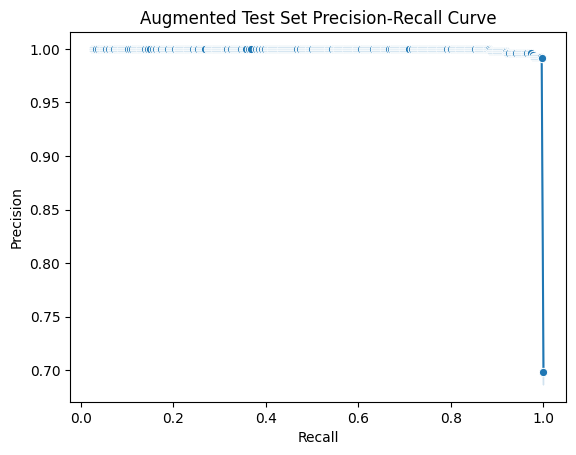

In [58]:
# Create a DataFrame for Seaborn
pr_data = pd.DataFrame({
    'Precision': precision[:-1],
    'Recall': recall[:-1],
    'F1 Score': f1_scores
})

# Plot Precision-Recall curve using Seaborn
sns.lineplot(data=pr_data, x='Recall', y='Precision', marker='o')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Augmented Test Set Precision-Recall Curve')
plt.show()

### Plot a ROC Curve for our Gold Labeled Data

We need to see the ROC Curve for our gold labeled data as well. We care more about performance on this data.

In [59]:
y_true = gold_df["Label"]
y_scores = gold_df.apply(sbert_match, axis=1)

In [60]:
# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

# Compute F1 score for each threshold
f1_scores = [f1_score(y_true, y_scores >= t) for t in thresholds]

# Find the threshold that maximizes the F1 score
best_threshold_index = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_index]
best_f1_score = f1_scores[best_threshold_index]

print(f'Best Threshold: {best_threshold}')
print(f'Best F1 Score: {best_f1_score}')

roc_auc = roc_auc_score(y_true, y_scores)
print(f'AUC-ROC: {roc_auc}')

Best Threshold: 0.9029672595166913
Best F1 Score: 0.8192771084337349
AUC-ROC: 0.781184668989547


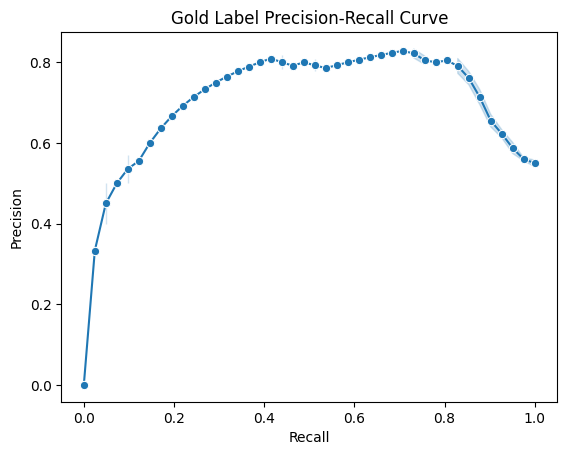

In [61]:
# Create a DataFrame for Seaborn
pr_data = pd.DataFrame({
    'Precision': precision[:-1],
    'Recall': recall[:-1],
    'F1 Score': f1_scores
})

# Plot Precision-Recall curve using Seaborn
sns.lineplot(data=pr_data, x='Recall', y='Precision', marker='o')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Gold Label Precision-Recall Curve')
plt.show()

### Debugging Errors on our Gold Labels

Let's evaluate the data using our `gold_label_report` function with the best F1 score. Then we can view the errors and figure out where our model is failing.

In [62]:
raw_df, grouped_df = gold_label_report(
    gold_df,
    [
        strict_parse_match,
        parse_match_country,
        sbert_match_binary,
    ],
    threshold=best_threshold
)

#### Label Description Group Analysis

You can see the types of address pairs we are failing on. This can guide our data augmentation / programmatic labeling work at a high level.

In [63]:
grouped_df.head(40)

,strict_parse_match_acc,parse_match_country_acc,sbert_match_binary_acc
Description,,,
Abbreviated street type for same address should match,0.0,0.0,1.000000
Abbreviated vs. full street names for same address should match,0.0,0.0,1.000000
Addition of parenthetical details for same address should match,0.0,0.0,1.000000
Adjacent or nearby building numbers means different address,0.0,0.0,0.000000
Close numerical variants are different addresses,0.0,0.0,0.000000
Common misspellings for same address should match,0.0,0.0,1.000000
Common typographical errors in same address should match,0.0,0.0,1.000000
Completely different addresses that don't match,0.0,0.0,0.000000
Different addresses in the same country that don't match,0.0,0.0,0.000000


In [64]:
grouped_df["sbert_match_binary_acc"].sort_values().head(40)

Description
Incomplete address vs full address may match                                             0.000000
Formal and localized format of same address should match                                 0.000000
Missing street suffix can mean different address                                         0.000000
Missing unit number in match means different address                                     0.000000
Different street name endings means different address                                    0.000000
Different states means different address                                                 0.000000
Different postal codes means different address                                           0.000000
Similar building names can be different addresses                                        0.000000
Different languages for same address should match                                        0.000000
Similar but different street numbers                                                     0.000000
Similar 

#### What it Got Right ...

In [65]:
# Truthiness analysis
correct_df = raw_df[raw_df["sbert_match_binary_correct"]].reset_index()
print(f"Number correct: {len(correct_df):,}")

correct_df.head(20)

Number correct: 61


,index,Description,Address1,Address2,Label,strict_parse_match,strict_parse_match_correct,parse_match_country,parse_match_country_correct,sbert_match_binary,sbert_match_binary_correct
0,0,Different directional prefix formats for same ...,"2024 NW 5th Ave, Miami, FL 33127","2024 Northwest 5th Avenue, Miami, Florida 33127",1,0,False,0,False,1,True
1,1,Abbreviated street type for same address shoul...,"10200 NE 12th St, Bellevue, WA 98003","10200 NE 12th Street, Bellevue, WA 98003",1,0,False,0,False,1,True
2,2,Common misspellings for same address should match,"1600 Pennsylvna Ave NW, Washington, DC 20500","1600 Pennsylvania Avenue NW, Washington, DC 20500",1,0,False,0,False,1,True
3,3,Different directional prefix formats for same ...,"550 S Hill St, Los Angeles, CA","550 South Hill Street, Los Angeles, California",1,0,False,0,False,1,True
4,5,Numerical variations for same address should m...,"Third Ave, New York, NY","3rd Avenue, New York, New York",1,0,False,0,False,1,True
5,6,Variant format of same address should match,"350 Fifth Avenue, New York, NY 10118","Empire State Bldg, 350 5th Ave, NY, NY 10118",1,0,False,0,False,1,True
6,7,Variant format of same address should match,"Çırağan Caddesi No: 32, 34349 Beşiktaş, Istanb...","Ciragan Palace Hotel, Ciragan Street 32, Besik...",1,0,False,0,False,1,True
7,10,Variant formats of same address should match,Shànghǎi Shì Huángpǔ Qū Nánjīng Dōng Lù 318 Hào,Shànghǎi Huángpǔ Nánjīng Dōng Lù 318 Hào,1,0,False,0,False,1,True
8,13,Missing state but has postal code and country ...,"Pariser Platz 2, 10117 Berlin, Germany","Pariser Platz 2, 10117 Berlin, Berlin, Germany",1,1,True,1,True,1,True
9,14,Missing state but has postal code and country ...,"Marienplatz 1, 80331 Munich, Germany","Marienplatz 1, 80331 Munich, Bavaria, Germany",1,1,True,1,True,1,True


In [66]:
# Error analysis
wrong_df = raw_df[raw_df["sbert_match_binary_correct"] == False].reset_index()
print(f"Number wrong: {len(wrong_df):,}")

wrong_df.head(20)

Number wrong: 15


,index,Description,Address1,Address2,Label,strict_parse_match,strict_parse_match_correct,parse_match_country,parse_match_country_correct,sbert_match_binary,sbert_match_binary_correct
0,4,Incomplete address vs full address may match,"1020 SW 2nd Ave, Portland","1020 SW 2nd Ave, Portland, OR 97204",1,0,False,0,False,0,False
1,8,Different character sets for same address shou...,北京市朝阳区建国路88号,Běijīng Shì Cháoyáng Qū Jiànguó Lù 88 Hào,1,0,False,0,False,0,False
2,9,Variant formats of same address should match,上海市黄浦区南京东路318号,上海黄浦南京东路318号,1,0,False,0,False,0,False
3,11,Formal and localized format of same address sh...,"B-14, Connaught Place, New Delhi, Delhi 110001...","B-14, CP, ND, DL 110001",1,0,False,0,False,0,False
4,12,Different character sets for same address shou...,"16, MG Road, Bangalore, Karnataka 560001, India","16, एमजी रोड, बैंगलोर, कर्नाटक 560001",1,0,False,0,False,0,False
5,16,Different languages for same address should match,北京市东城区东长安街16号,"16 Dongchang'an St, Dongcheng, Beijing, China",1,0,False,0,False,0,False
6,32,Typographical errors in same address with coun...,"Calle Mayor, 10, 28013 Madrid, España","Calle Mayor, 10, 28013 Madird, España",1,1,True,0,False,0,False
7,42,Different street names means different address,"101 Market Square, Seattle, WA 98039","101 Davis Place, Seattle, WA 98039",0,0,True,0,True,1,False
8,52,Similar road names can be different addresses,北京市朝阳区朝阳门外大街6号,北京市朝阳区朝阳门内大街6号,0,0,True,0,True,1,False
9,53,Similar road names can be different addresses,Běijīng Shì Cháoyáng Qū Cháoyángmén Wài Dàjiē ...,Běijīng Shì Cháoyáng Qū Cháoyángmén Nèi Dàjiē ...,0,0,True,0,True,1,False


# Fuzzy, Structured Address Matching with Libpostal and Vector Distance

There seems to be merit to both structured and embedding approaches to address matching. Let's see how an approximate approach to matching parsed address components might help.

## Combining an Address Parsing and Embedding Approach

Libpostal is a powerful parsing model, and it seems like parsing is a logical first step in matching addresses. Some logical combinations of fields should result in a match, while some should not. This logic can be programmed by a human, provided fuzzy matching is available at the field level. `101 Oak Lane` should match `101 Oak Ln` but not `102 Oak Lane`. `street_name` and `street_number` are separate fields in an address parsed by Libpostal. What is we got some machine learning help with field-level matching?

In [67]:
sbert_compare("Oak Lane", "Oak Ln.")

0.9542929936396678

In [68]:
sbert_compare("Cheer Lane", "Cheer Road")

0.6786135696592164

In [69]:
sbert_compare("101", "110")

0.528882754814667

In [70]:
sbert_compare("5th", "Fifth")

0.9581862600450676

In [71]:
sbert_compare("USA", "United States")

0.9903042161520489

In [72]:
sbert_compare("30044", "30308")

0.25819592340288156

## Fine-Tuning a Lowercase `SentenceTransformer`

My first pass at this method did not work whatsoever - the performance of the matcher was abysmal. This was because Libpostal *lowercases* addresses when it parses them, and I did NOT do that to the training data on a first pass :) Once I did that and retrained below - things worked much better!

### Lowercase our Dataset

In [73]:
lower_augment_results_df = augment_results_df.copy(deep=True)

lower_augment_results_df["Address1"] = lower_augment_results_df["Address1"].str.lower()
lower_augment_results_df["Address2"] = lower_augment_results_df["Address2"].str.lower()

In [74]:
train_df, tmp_df = train_test_split(lower_augment_results_df, test_size=0.2, shuffle=True)
eval_df, test_df = train_test_split(tmp_df, test_size=0.5, random_state=42, shuffle=True)

train_dataset = Dataset.from_dict({
    "sentence1": train_df["Address1"].tolist(),
    "sentence2": train_df["Address2"].tolist(),
    "label": train_df["Label"].tolist(),
})

eval_dataset = Dataset.from_dict({
    "sentence1": eval_df["Address1"].tolist(),
    "sentence2": eval_df["Address2"].tolist(),
    "label": eval_df["Label"].tolist(),
})

test_dataset = Dataset.from_dict({
    "sentence1": test_df["Address1"].tolist(),
    "sentence2": test_df["Address2"].tolist(),
    "label": test_df["Label"].tolist(),
})

print(f"Training data:   {len(train_df):,}")
print(f"Validation data: {len(eval_df):,}")
print(f"Test data        {len(eval_df):,}")

Training data:   8,024
Validation data: 1,003
Test data        1,003


In [75]:
SBERT_MODEL = "paraphrase-multilingual-MiniLM-L12-v2"
VARIANT = "lowercase"
MODEL_SAVE_NAME = (SBERT_MODEL + "-" + VARIANT).replace("/", "-")

EPOCHS = 6
BATCH_SIZE = 32
PATIENCE = 3
LEARNING_RATE = .00005
DATASET_MULTIPLE = CLONES_PER_RUN * RUNS_PER_EXAMPLE
SBERT_LOWER_OUTPUT_FOLDER = f"data/fine-tuned-sbert-{MODEL_SAVE_NAME}"
SAVE_EVAL_STEPS = 100

In [76]:
# Initialize Weights & Biases
wandb.init(
    entity="rjurney",
    # set the wandb project where this run will be logged
    project="libpostal-reborn",
    # track hyperparameters and run metadata
    config={
        "variant": VARIANT,
        "dataset_multiple": DATASET_MULTIPLE,
        "epochs": EPOCHS,
        "batch_size": BATCH_SIZE,
        "patience": PATIENCE,
        "learning_rate": LEARNING_RATE,
        "sbert_model": SBERT_MODEL,
        "sbert_output_folder": SBERT_LOWER_OUTPUT_FOLDER,
        "save_eval_steps": SAVE_EVAL_STEPS,
    },
)

In [77]:
sbert_model_lower = SentenceTransformer(
    SBERT_MODEL,
    device=device,
    model_card_data=SentenceTransformerModelCardData(
        language="en",
        license="apache-2.0",
        model_name=f"{SBERT_MODEL}-address-matcher-{VARIANT}",
    ),
)

In [78]:
# Initialize the evaluator
binary_acc_evaluator = BinaryClassificationEvaluator(
    sentences1=eval_dataset["sentence1"],
    sentences2=eval_dataset["sentence2"],
    labels=eval_dataset["label"],
    name=SBERT_MODEL,
)
binary_acc_evaluator(sbert_model_lower)

{'paraphrase-multilingual-MiniLM-L12-v2_cosine_accuracy': 0.555333998005982,
 'paraphrase-multilingual-MiniLM-L12-v2_cosine_accuracy_threshold': 0.5671517252922058,
 'paraphrase-multilingual-MiniLM-L12-v2_cosine_f1': 0.6936813186813185,
 'paraphrase-multilingual-MiniLM-L12-v2_cosine_f1_threshold': 0.5671517252922058,
 'paraphrase-multilingual-MiniLM-L12-v2_cosine_precision': 0.5332629355860612,
 'paraphrase-multilingual-MiniLM-L12-v2_cosine_recall': 0.9921414538310412,
 'paraphrase-multilingual-MiniLM-L12-v2_cosine_ap': 0.4555092424450611,
 'paraphrase-multilingual-MiniLM-L12-v2_dot_accuracy': 0.5623130608175474,
 'paraphrase-multilingual-MiniLM-L12-v2_dot_accuracy_threshold': 19.140213012695312,
 'paraphrase-multilingual-MiniLM-L12-v2_dot_f1': 0.6810519217801752,
 'paraphrase-multilingual-MiniLM-L12-v2_dot_f1_threshold': 7.704103469848633,
 'paraphrase-multilingual-MiniLM-L12-v2_dot_precision': 0.5184804928131417,
 'paraphrase-multilingual-MiniLM-L12-v2_dot_recall': 0.9921414538310412

In [79]:
# This will rapidly train the embedding model. MultipleNegativesRankingLoss did not work.
loss = losses.ContrastiveLoss(model=sbert_model_lower)

sbert_args = SentenceTransformerTrainingArguments(
    output_dir=SBERT_LOWER_OUTPUT_FOLDER,
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    warmup_ratio=0.1,
    run_name=SBERT_MODEL,
    load_best_model_at_end=True,
    save_steps=SAVE_EVAL_STEPS,
    eval_steps=SAVE_EVAL_STEPS,
    save_strategy="steps",
    eval_strategy="steps",
    greater_is_better=False,
    metric_for_best_model="eval_loss",
    learning_rate=LEARNING_RATE,
    logging_dir="./logs",
)

trainer = SentenceTransformerTrainer(
    model=sbert_model_lower,
    args=sbert_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    loss=loss,
    evaluator=binary_acc_evaluator,
    compute_metrics=compute_sbert_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=PATIENCE)],
)

trainer.evaluate()
trainer.train()

Step,Training Loss,Validation Loss,Paraphrase-multilingual-minilm-l12-v2 Cosine Accuracy,Paraphrase-multilingual-minilm-l12-v2 Cosine Accuracy Threshold,Paraphrase-multilingual-minilm-l12-v2 Cosine F1,Paraphrase-multilingual-minilm-l12-v2 Cosine F1 Threshold,Paraphrase-multilingual-minilm-l12-v2 Cosine Precision,Paraphrase-multilingual-minilm-l12-v2 Cosine Recall,Paraphrase-multilingual-minilm-l12-v2 Cosine Ap,Paraphrase-multilingual-minilm-l12-v2 Dot Accuracy,Paraphrase-multilingual-minilm-l12-v2 Dot Accuracy Threshold,Paraphrase-multilingual-minilm-l12-v2 Dot F1,Paraphrase-multilingual-minilm-l12-v2 Dot F1 Threshold,Paraphrase-multilingual-minilm-l12-v2 Dot Precision,Paraphrase-multilingual-minilm-l12-v2 Dot Recall,Paraphrase-multilingual-minilm-l12-v2 Dot Ap,Paraphrase-multilingual-minilm-l12-v2 Manhattan Accuracy,Paraphrase-multilingual-minilm-l12-v2 Manhattan Accuracy Threshold,Paraphrase-multilingual-minilm-l12-v2 Manhattan F1,Paraphrase-multilingual-minilm-l12-v2 Manhattan F1 Threshold,Paraphrase-multilingual-minilm-l12-v2 Manhattan Precision,Paraphrase-multilingual-minilm-l12-v2 Manhattan Recall,Paraphrase-multilingual-minilm-l12-v2 Manhattan Ap,Paraphrase-multilingual-minilm-l12-v2 Euclidean Accuracy,Paraphrase-multilingual-minilm-l12-v2 Euclidean Accuracy Threshold,Paraphrase-multilingual-minilm-l12-v2 Euclidean F1,Paraphrase-multilingual-minilm-l12-v2 Euclidean F1 Threshold,Paraphrase-multilingual-minilm-l12-v2 Euclidean Precision,Paraphrase-multilingual-minilm-l12-v2 Euclidean Recall,Paraphrase-multilingual-minilm-l12-v2 Euclidean Ap,Paraphrase-multilingual-minilm-l12-v2 Max Accuracy,Paraphrase-multilingual-minilm-l12-v2 Max Accuracy Threshold,Paraphrase-multilingual-minilm-l12-v2 Max F1,Paraphrase-multilingual-minilm-l12-v2 Max F1 Threshold,Paraphrase-multilingual-minilm-l12-v2 Max Precision,Paraphrase-multilingual-minilm-l12-v2 Max Recall,Paraphrase-multilingual-minilm-l12-v2 Max Ap
100,No log,0.030212,0.715852,0.847625,0.765714,0.834917,0.655028,0.921415,0.714015,0.710867,11.413269,0.749810,8.911697,0.611663,0.968566,0.780366,0.678963,27.534477,0.734959,35.465191,0.626907,0.888016,0.674622,0.681954,1.663839,0.734095,2.264982,0.627615,0.884086,0.674834,0.715852,27.534477,0.765714,35.465191,0.655028,0.968566,0.780366
200,No log,0.019866,0.846461,0.885110,0.859964,0.862651,0.791736,0.941061,0.905718,0.826520,11.561327,0.838590,11.561327,0.794376,0.888016,0.897641,0.792622,27.062531,0.804878,28.744329,0.770197,0.842829,0.848968,0.791625,1.808093,0.802733,2.212044,0.709970,0.923379,0.850513,0.846461,27.062531,0.859964,28.744329,0.794376,0.941061,0.905718
300,No log,0.012051,0.936191,0.908225,0.937008,0.908225,0.938856,0.935167,0.969412,0.847458,16.046368,0.844985,16.046368,0.872385,0.819253,0.929795,0.900299,33.788952,0.906716,33.951641,0.863233,0.954813,0.948477,0.900299,1.921761,0.906191,2.151567,0.867145,0.948919,0.949428,0.936191,33.788952,0.937008,33.951641,0.938856,0.954813,0.969412
400,No log,0.007848,0.957129,0.887224,0.958534,0.869930,0.941288,0.976424,0.984128,0.884347,13.915003,0.885090,12.717066,0.856618,0.915521,0.958301,0.925224,29.553307,0.927014,34.871883,0.895604,0.960707,0.970987,0.926221,2.001398,0.927894,2.223032,0.897248,0.960707,0.971320,0.957129,29.553307,0.958534,34.871883,0.941288,0.976424,0.984128
500,0.014300,0.004851,0.975075,0.881183,0.975752,0.857977,0.963602,0.988212,0.990374,0.911266,11.269165,0.916117,11.230205,0.880435,0.954813,0.966869,0.958126,32.887955,0.959302,34.078728,0.946463,0.972495,0.982282,0.959123,2.232162,0.960386,2.232162,0.944867,0.976424,0.982454,0.975075,32.887955,0.975752,34.078728,0.963602,0.988212,0.990374
600,0.014300,0.004339,0.974078,0.881324,0.974560,0.881324,0.970760,0.978389,0.992946,0.933200,13.773317,0.934249,13.681917,0.933333,0.935167,0.978131,0.958126,32.534729,0.958984,33.264679,0.953398,0.964637,0.985562,0.959123,2.074340,0.959922,2.074340,0.955253,0.964637,0.985839,0.974078,32.534729,0.974560,33.264679,0.970760,0.978389,0.992946
700,0.014300,0.003481

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

TrainOutput(global_step=1506, training_loss=0.0058323503311124856, metrics={'train_runtime': 320.0626, 'train_samples_per_second': 150.421, 'train_steps_per_second': 4.705, 'total_flos': 0.0, 'train_loss': 0.0058323503311124856, 'epoch': 6.0})

In [80]:
trainer.evaluate()

{'eval_loss': 0.001999415224418044,
 'eval_paraphrase-multilingual-MiniLM-L12-v2_cosine_accuracy': 0.9860418743768694,
 'eval_paraphrase-multilingual-MiniLM-L12-v2_cosine_accuracy_threshold': 0.8781681060791016,
 'eval_paraphrase-multilingual-MiniLM-L12-v2_cosine_f1': 0.9863813229571985,
 'eval_paraphrase-multilingual-MiniLM-L12-v2_cosine_f1_threshold': 0.8310675621032715,
 'eval_paraphrase-multilingual-MiniLM-L12-v2_cosine_precision': 0.976878612716763,
 'eval_paraphrase-multilingual-MiniLM-L12-v2_cosine_recall': 0.9960707269155207,
 'eval_paraphrase-multilingual-MiniLM-L12-v2_cosine_ap': 0.998403753279045,
 'eval_paraphrase-multilingual-MiniLM-L12-v2_dot_accuracy': 0.9611166500498505,
 'eval_paraphrase-multilingual-MiniLM-L12-v2_dot_accuracy_threshold': 15.609647750854492,
 'eval_paraphrase-multilingual-MiniLM-L12-v2_dot_f1': 0.962607861936721,
 'eval_paraphrase-multilingual-MiniLM-L12-v2_dot_f1_threshold': 13.579381942749023,
 'eval_paraphrase-multilingual-MiniLM-L12-v2_dot_precisio

### Rewrite our Matchers for Lowercase Duty

Need two versions of these to compare the original with their new lowercase cousins.

In [81]:
def sbert_compare_lower(address1: str, address2: str) -> float:
    """sbert_compare - sentence encode each address into a fixed-length text embedding.
    Fixed-length means they can be compared with cosine similarity."""
    embedding1 = sbert_model_lower.encode(address1.lower())
    embedding2 = sbert_model_lower.encode(address2.lower())

    # Compute cosine similarity
    return 1 - distance.cosine(embedding1, embedding2)


def sbert_match_lower(row: pd.Series) -> pd.Series:
    """sbert_match - SentenceTransformer address matching, float iytoyt"""
    return sbert_compare_lower(row["Address1"], row["Address2"])


def sbert_compare_binary_lower(address1: str, address2: str, threshold: float = 0.5) -> Literal[0, 1]:
    """sbert_match - compare and return a binary match"""
    similarity = sbert_compare_lower(address1, address2)
    return 1 if similarity >= threshold else 0


def sbert_match_binary_lower(row: pd.Series, threshold: float = 0.5) -> pd.Series:
    """sbert_match_binary - SentenceTransformer address matching, binary output"""
    return sbert_compare_binary_lower(row["Address1"], row["Address2"], threshold=threshold)

### Evaluate ROC Curve to Determine Optimum Similarity Threshold

We need to evaluate the ROC Curve of the F1 score to see what it should be set to for our lowercase model too. Recall that the `sbert_match_lower` function has a `threshold: float = 0.5` argument.

#### Evaluate on our Augmented Test Dataset

First we'll evaluate the ROC curve on our augmented test dataset.

In [82]:
y_true = test_df["Label"]
y_scores = test_df.apply(sbert_match_lower, axis=1)

In [83]:
# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

# Compute F1 score for each threshold
f1_scores = [f1_score(y_true, y_scores >= t) for t in thresholds]

# Find the threshold that maximizes the F1 score
best_threshold_index = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_index]
best_f1_score = f1_scores[best_threshold_index]

print(f'Best Threshold: {best_threshold}')
print(f'Best F1 Score: {best_f1_score}')

roc_auc = roc_auc_score(y_true, y_scores)
print(f'AUC-ROC: {roc_auc}')

Best Threshold: 0.847761044498234
Best F1 Score: 0.9907578558225508
AUC-ROC: 0.9984366003454673


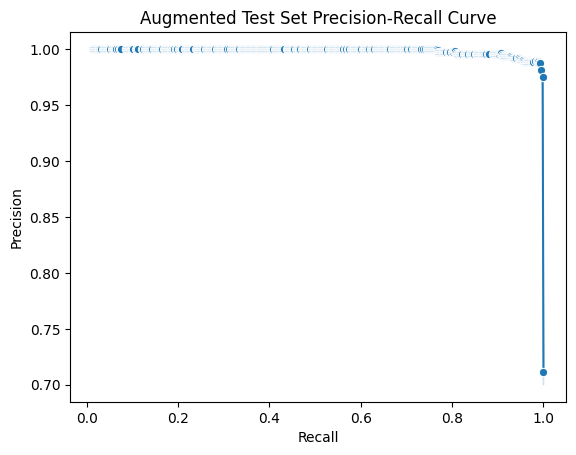

In [84]:
# Create a DataFrame for Seaborn
pr_data = pd.DataFrame({
    'Precision': precision[:-1],
    'Recall': recall[:-1],
    'F1 Score': f1_scores
})

# Plot Precision-Recall curve using Seaborn
sns.lineplot(data=pr_data, x='Recall', y='Precision', marker='o')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Augmented Test Set Precision-Recall Curve')
plt.show()

### Plot a ROC Curve for our Gold Labeled Data

We need to see the ROC Curve for our gold labeled data as well. We care more about performance on this data.

In [85]:
y_true = gold_df["Label"]
y_scores = gold_df.apply(sbert_match_lower, axis=1)

In [86]:
# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

# Compute F1 score for each threshold
f1_scores = [f1_score(y_true, y_scores >= t) for t in thresholds]

# Find the threshold that maximizes the F1 score
best_threshold_index = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_index]
best_f1_score = f1_scores[best_threshold_index]

print(f'Best Threshold: {best_threshold}')
print(f'Best F1 Score: {best_f1_score}')

roc_auc = roc_auc_score(y_true, y_scores)
print(f'AUC-ROC: {roc_auc}')

Best Threshold: 0.9192699469837062
Best F1 Score: 0.8235294117647058
AUC-ROC: 0.7937282229965157


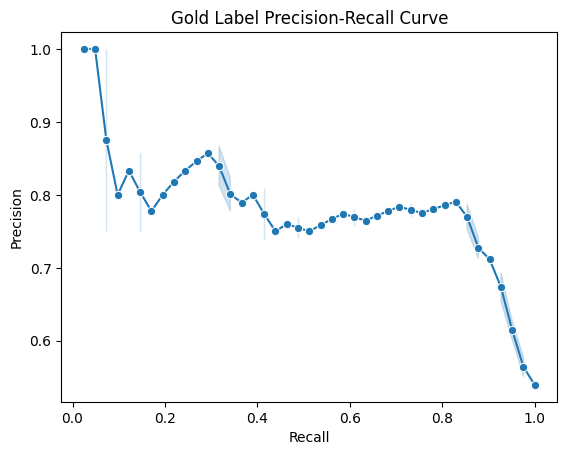

In [87]:
# Create a DataFrame for Seaborn
pr_data = pd.DataFrame({
    'Precision': precision[:-1],
    'Recall': recall[:-1],
    'F1 Score': f1_scores
})

# Plot Precision-Recall curve using Seaborn
sns.lineplot(data=pr_data, x='Recall', y='Precision', marker='o')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Gold Label Precision-Recall Curve')
plt.show()

### Rewriting our Structured Matcher to be Semantically Fuzzy

Let's rewrite our original parser to use `sbert_compare_binary(address1: str, address2: str, threshold=best_threshold)` for the road name, city (which we skipped before) and country.

In [88]:
def parse_fuzzy_match_address(address1: str, address2: str, threshold=0.5) -> Literal[0, 1]:
    """parse_fuzzy_match_address uses parsed addresses with fuzzy matching for street, city and country."""
    address1 = to_dict(parse_address(address1))
    address2 = to_dict(parse_address(address2))

    def match_road(address1: Dict, address2: Dict) -> Literal[0, 1]:
        """match_road - literal road matching, negative if either lacks a road"""
        if ("road" in address1) and ("road" in address2):

            # to_dict produces a list if two tuples have the same key
            if isinstance(address1["road"], list):
                address1["road"] = " ".join(address1["road"])
            if isinstance(address2["road"], list):
                address2["road"] = " ".join(address2["road"])
            
            if sbert_compare_binary_lower(
                address1["road"],
                address2["road"], 
                threshold=threshold
            ):
                logger.debug("road match")
                return 1
            else:
                logger.debug("road mismatch")
                return 0
        logger.debug("road mismatch")
        return 0

    def match_house_number(address1: Dict, address2: Dict) -> Literal[0, 1]:
        """match_house_number - literal house number matching, negative if either lacks a house_number"""
        if ("house_number" in address1) and ("house_number" in address2):
            if address1["house_number"] == address2["house_number"]:
                logger.debug("house_number match")
                return 1
            else:
                logger.debug("house_number mismatch")
                return 0
        logger.debug("house_number mistmatch")
        return 0

    def match_unit(address1: Dict, address2: Dict) -> Literal[0, 1]:
        """match_unit - note a missing unit in both is a match"""
        if "unit" in address1:
            if "unit" in address2:
                logger.debug("unit match")
                return 1 if (address1["unit"] == address2["unit"]) else 0
            else:
                logger.debug("unit mismatch")
                return 0
        if "unit" in address2:
            if "unit" in address1:
                logger.debug("unit match")
                return 1 if (address1["unit"] == address2["unit"]) else 0
            else:
                logger.debug("unit mismatch")
                return 0
        # Neither address has a unit, which is a default match
        return 1

    def match_postcode(address1: Dict, address2: Dict) -> Literal[0, 1]:
        """match_postcode - literal matching, negative if either lacks a postal code"""
        if ("postcode" in address1) and ("postcode" in address2):
            if address1["postcode"] == address2["postcode"]:
                logger.debug("postcode match")
                return 1
            else:
                logger.debug("postcode mismatch")
                return 0
        logger.debug("postcode mismatch")
        return 0

    def match_country(address1: Dict, address2: Dict) -> Literal[0, 1]:
        """match_country - literal country matching - pass if both don't have one"""
        if ("country" in address1) and ("country" in address2):

            # to_dict produces a list if two tuples have the same key
            if isinstance(address1["country"], list):
                address1["country"] = " ".join(address1["country"])
            if isinstance(address2["country"], list):
                address2["country"] = " ".join(address2["country"])

            if sbert_compare_binary_lower(
                address1["country"],
                address2["country"],
                threshold=best_threshold,
            ):
                logger.debug("country match")
                return 1
            else:
                logger.debug("country mismatch")
                return 0

        # One or none countries should match
        logger.debug("country match")
        return 1

    # Combine the above to get a complete address matcher
    if (
        match_road(address1, address2)
        and match_house_number(address1, address2)
        and match_unit(address1, address2)
        and match_postcode(address1, address2)
        and match_country(address1, address2)
    ):
        logger.debug("overall match")
        return 1
    else:
        logger.debug("overall mismatch")
        return 0


def sbert_parse_match(row: pd.Series, threshold: float = 0.5) -> pd.Series:
    """fuzzy_parse_match Fuzzy, structured address matching. Threshold is passed through via gold_label_report."""
    return parse_fuzzy_match_address(row["Address1"], row["Address2"], threshold=threshold)

In [89]:
raw_df, grouped_df = gold_label_report(
    gold_df,
    [
        strict_parse_match,
        parse_match_country,
        sbert_match_binary,
        sbert_parse_match,
    ],
    threshold=best_threshold
)

In [90]:
grouped_df["sbert_parse_match_acc"].sort_values().head(40)

Description
Incomplete address vs full address may match                                             0.0
Variant format of same address should match                                              0.0
Intersection vs addresss for same location should match                                  0.0
Local vs. international formatting for same address should match                         0.0
Missing postal code can mean different address                                           0.0
Missing street suffix can mean different address                                         0.0
Missing unit number in match means different address                                     0.0
Normal vs abbreviated country name for same address should match                         0.0
Normal vs formal country names for same address should match                             0.0
Numeric or written street number for same address should match                           0.0
Numerical variations for same address should match        

In [91]:
# Truthiness analysis
correct_df = raw_df[raw_df["sbert_parse_match_correct"]].reset_index(drop=True)
print(f"Number correct: {len(correct_df):,}")

correct_df.head(20)

Number correct: 48


,Description,Address1,Address2,Label,strict_parse_match,strict_parse_match_correct,parse_match_country,parse_match_country_correct,sbert_match_binary,sbert_match_binary_correct,sbert_parse_match,sbert_parse_match_correct
0,Different directional prefix formats for same ...,"2024 NW 5th Ave, Miami, FL 33127","2024 Northwest 5th Avenue, Miami, Florida 33127",1,0,False,0,False,1,True,1,True
1,Abbreviated street type for same address shoul...,"10200 NE 12th St, Bellevue, WA 98003","10200 NE 12th Street, Bellevue, WA 98003",1,0,False,0,False,1,True,1,True
2,Missing state but has postal code and country ...,"Pariser Platz 2, 10117 Berlin, Germany","Pariser Platz 2, 10117 Berlin, Berlin, Germany",1,1,True,1,True,1,True,1,True
3,Missing state but has postal code and country ...,"Marienplatz 1, 80331 Munich, Germany","Marienplatz 1, 80331 Munich, Bavaria, Germany",1,1,True,1,True,1,True,1,True
4,Same address with and without country should m...,"1600 Amphitheatre Parkway, Mountain View, CA 9...","1600 Amphitheatre Parkway, Mountain View, CA 9...",1,1,True,1,True,1,True,1,True
5,Same address with and without country should m...,"3413 Sean Way, Lawrenceville, GA 30044, U.S.A.","3413 Sean Way, Lawrenceville, Georgia, 30044",1,1,True,1,True,0,False,1,True
6,Including and excluding building names for sam...,"The Empire State Building, 350 5th Ave, New Yo...","350 5th Ave, New York, NY 10118",1,1,True,1,True,1,True,1,True
7,Floor bumbers included or excluded for same ad...,"350 5th Ave, 86th Floor, New York, NY 10118","350 5th Ave, New York, NY 10118",1,1,True,1,True,1,True,1,True
8,Same address incorporates business name or not...,"Google, 1600 Amphitheatre Parkway, Mountain Vi...","1600 Amphitheatre Parkway, Mountain View, CA 9...",1,1,True,1,True,1,True,1,True
9,Typographical errors in same address with coun...,"Calle Mayor, 10, 28013 Madrid, España","Calle Mayor, 10, 28013 Madird, España",1,1,True,0,False,0,False,1,True


In [92]:
# Error analysis
wrong_df = raw_df[raw_df["sbert_parse_match_correct"] == False].reset_index()
print(f"Number wrong: {len(wrong_df):,}")

wrong_df.head(20)

Number wrong: 28


,index,Description,Address1,Address2,Label,strict_parse_match,strict_parse_match_correct,parse_match_country,parse_match_country_correct,sbert_match_binary,sbert_match_binary_correct,sbert_parse_match,sbert_parse_match_correct
0,2,Common misspellings for same address should match,"1600 Pennsylvna Ave NW, Washington, DC 20500","1600 Pennsylvania Avenue NW, Washington, DC 20500",1,0,False,0,False,1,True,0,False
1,3,Different directional prefix formats for same ...,"550 S Hill St, Los Angeles, CA","550 South Hill Street, Los Angeles, California",1,0,False,0,False,1,True,0,False
2,4,Incomplete address vs full address may match,"1020 SW 2nd Ave, Portland","1020 SW 2nd Ave, Portland, OR 97204",1,0,False,0,False,0,False,0,False
3,5,Numerical variations for same address should m...,"Third Ave, New York, NY","3rd Avenue, New York, New York",1,0,False,0,False,1,True,0,False
4,6,Variant format of same address should match,"350 Fifth Avenue, New York, NY 10118","Empire State Bldg, 350 5th Ave, NY, NY 10118",1,0,False,0,False,1,True,0,False
5,7,Variant format of same address should match,"Çırağan Caddesi No: 32, 34349 Beşiktaş, Istanb...","Ciragan Palace Hotel, Ciragan Street 32, Besik...",1,0,False,0,False,1,True,0,False
6,8,Different character sets for same address shou...,北京市朝阳区建国路88号,Běijīng Shì Cháoyáng Qū Jiànguó Lù 88 Hào,1,0,False,0,False,0,False,0,False
7,9,Variant formats of same address should match,上海市黄浦区南京东路318号,上海黄浦南京东路318号,1,0,False,0,False,0,False,0,False
8,10,Variant formats of same address should match,Shànghǎi Shì Huángpǔ Qū Nánjīng Dōng Lù 318 Hào,Shànghǎi Huángpǔ Nánjīng Dōng Lù 318 Hào,1,0,False,0,False,1,True,0,False
9,11,Formal and localized format of same address sh...,"B-14, Connaught Place, New Delhi, Delhi 110001...","B-14, CP, ND, DL 110001",1,0,False,0,False,0,False,0,False


In [93]:
sbert_compare_lower(
    "nw 5th ave",
    "northwest 5th avenue"
)

0.9627521079724

In [94]:
parse_fuzzy_match_address(
    "2024 NW 5th Ave, Miami, FL 33127",
    "2024 Northwest 5th Avenue, Miami, Florida 33127",
    threshold=best_threshold
)

1

In [95]:
parse_fuzzy_match_address(
    "Third Ave, New York, NY",
    "3rd Avenue, New York, New York"
)

0

In [96]:
sbert_compare_lower(
    "101 market square, seattle, wa 98039",
    "101 davis place, seattle, wa 98039"
)

0.9164835356827398

In [97]:
parse_fuzzy_match_address(
    "221B Baker Street, London, NW1 6XE, UK",
    "221B Baker St, Marylebone, London NW1 6XE"
)

1

Not quite right... we didn't come close to beating sentence transformers alone. I think we really need a deep learning model doing the heavy lifting for us rather than a simple threshold on a binary classification.

## Fuzzy Parsed Conclusion

If you look at the items missed by this model, they are largely due to stricter matching requirements. These could be addressed logically, as with the help of fuzzy matching with `SentenceTransformers` they fall within the scope of task a human can accomplish. This means the structured, fuzzy model can be trusted more than the pure `SentenceTransformer` model. A little more work could bring it into a state that meets or beats the pure `SentenceTransformer` model while providing explainability that entity resolution often requires.

## Structured Prediction with a `Sentence-BERT` Classifier

Embeddings as a solution to this problem have a side-effect of optimizing an embedding for information retrieval... but they ignore the structure of parsed addresses. A deep network that is aware of it can perform better. Let's try out an implementation of the Sentence-BERT model, which was outlined by Nils Reimers and Iryna Gurevych in the original paper that created sentence tranformers, [Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks
](https://arxiv.org/abs/1908.10084).

In [142]:
SBERT_MODEL = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
VARIANT = "untrained-embeddings"
MODEL_SAVE_NAME = ("Sentence-BERT" + "-" + VARIANT).replace("/", "-")

EPOCHS = 6
BATCH_SIZE = 32
PATIENCE = 3
LEARNING_RATE = 2e-5
MODEL_OUTPUT_FOLDER = f"data/{MODEL_SAVE_NAME}"
SAVE_EVAL_STEPS = 100

COLUMN_SPECIAL_CHAR = "[COL]"
VALUE_SPECIAL_CHAR = "[VAL]"

In [143]:
# Initialize Weights & Biases
wandb.init(
    entity="rjurney",
    # set the wandb project where this run will be logged
    project="libpostal-reborn",
    # track hyperparameters and run metadata
    config={
        "model": "Sentence-BERT",
        "variant": VARIANT,
        "epochs": EPOCHS,
        "batch_size": BATCH_SIZE,
        "patience": PATIENCE,
        "learning_rate": LEARNING_RATE,
        "sbert_model": SBERT_OUTPUT_FOLDER,
        "model_output_folder": MODEL_OUTPUT_FOLDER,
        "save_eval_steps": SAVE_EVAL_STEPS,
        "model_save_name": MODEL_SAVE_NAME,
    },
)

In [192]:
class SentenceBERT(torch.nn.Module):
    def __init__(self, model_name=SBERT_MODEL, dim=384):
        super().__init__()
        self.model_name = model_name
        self.tokenizer = AutoTokenizer.from_pretrained("data/fine-tuned-sbert-paraphrase-multilingual-MiniLM-L12-v2-original/checkpoint-2400/")
        self.model = AutoModel.from_pretrained("data/fine-tuned-sbert-paraphrase-multilingual-MiniLM-L12-v2-original/checkpoint-2400/")
        self.ffnn = torch.nn.Linear(dim*3, 1)

    @staticmethod
    def mean_pool(token_embeds, attention_mask):
        in_mask = attention_mask.unsqueeze(-1).expand(token_embeds.size()).float()
        pool = torch.sum(token_embeds * in_mask, 1) / torch.clamp(in_mask.sum(1), min=1e-9)
        return pool

    def _check_similarity(self, a, b, mask_a, mask_b):
        u = self.model(a, attention_mask=mask_a)[0]
        v = self.model(b, attention_mask=mask_b)[0]
        u = SentenceBERT.mean_pool(u, mask_a)
        v = SentenceBERT.mean_pool(v, mask_b)
        uv = torch.abs(u - v)
        x = torch.cat([u, v, uv], dim=-1)
        x = torch.sigmoid(self.ffnn(x).float())
        return x

    def check_similarity(self, a, b):
        encoded_a = self.tokenizer(a, padding=True, truncation=True, return_tensors='pt')
        encoded_b = self.tokenizer(b, padding=True, truncation=True, return_tensors='pt')
        a = encoded_a['input_ids']
        b = encoded_b['input_ids']
        mask_a = encoded_a['attention_mask']
        mask_b = encoded_b['attention_mask']
        with torch.no_grad():
            return self._check_similarity(a, b, mask_a, mask_b)

    def forward(self, input_ids_a, input_ids_b, attention_mask_a=None, attention_mask_b=None, labels=None):
        logits = self._check_similarity(input_ids_a, input_ids_b, attention_mask_a, attention_mask_b)
        loss = None
        if labels is not None:
            loss_fct = torch.nn.BCEWithLogitsLoss()
            loss = loss_fct(logits.view(-1), labels.float().view(-1))
        return {"loss": loss, "logits": logits} if loss is not None else {"logits": logits}

    def predict(self, a: str, b: str):
        with torch.no_grad():
            logits = self.check_similarity(a, b)
            probabilities = torch.sigmoid(logits)
            predicted_class = (probabilities > 0.5).long().item()
            return predicted_class, probabilities.item()

In [193]:
classifier_model = SentenceBERT()

In [194]:
def structured_encode_address(address: str) -> str:
    """structured_parse_address - encode a parsed address"""
    parsed_address: List[Tuple[str, str]] = parse_address(address)
    sorted_address: List[Tuple[str, str]] = list(sorted(parsed_address, key=lambda x: x[1]))  # no secondary sort to maek it determinstic?
    encoded_address: str = str()
    for val, col in sorted_address:
        encoded_address += COLUMN_SPECIAL_CHAR + col + VALUE_SPECIAL_CHAR + val
    return encoded_address


def tokenize_function(examples):
    encoded_a = classifier_model.tokenizer(examples["sentence1"], padding="max_length", truncation=True)
    encoded_b = classifier_model.tokenizer(examples["sentence2"], padding="max_length", truncation=True)
    return {
        "input_ids_a": encoded_a["input_ids"],
        "attention_mask_a": encoded_a["attention_mask"],
        "input_ids_b": encoded_b["input_ids"],
        "attention_mask_b": encoded_b["attention_mask"],
        "labels": examples["label"]
    }


def format_dataset(dataset):
    dataset.set_format(type="torch", columns=["input_ids_a", "attention_mask_a", "input_ids_b", "attention_mask_b", "labels"])
    return dataset

In [195]:
train_df, tmp_df = train_test_split(augment_results_df, test_size=0.2, shuffle=True)
eval_df, test_df = train_test_split(tmp_df, test_size=0.5, random_state=42, shuffle=True)

# Encode the addresses using [COL] / [VAL] special characters
train_dataset = Dataset.from_dict({
    "sentence1": [structured_encode_address(x) for x in train_df["Address1"].tolist()],
    "sentence2": [structured_encode_address(x) for x in train_df["Address2"].tolist()],
    "label": train_df["Label"].tolist(),
})

# Encode the addresses using [COL] / [VAL] special characters
eval_dataset = Dataset.from_dict({
    "sentence1": [structured_encode_address(x) for x in eval_df["Address1"].tolist()],
    "sentence2": [structured_encode_address(x) for x in eval_df["Address2"].tolist()],
    "label": eval_df["Label"].tolist(),
})

# Encode the addresses using [COL] / [VAL] special characters
test_dataset = Dataset.from_dict({
    "sentence1": [structured_encode_address(x) for x in test_df["Address1"].tolist()],
    "sentence2": [structured_encode_address(x) for x in test_df["Address2"].tolist()],
    "label": test_df["Label"].tolist(),
})

print(f"Training data:   {len(train_df):,}")
print(f"Validation data: {len(eval_df):,}")
print(f"Test data        {len(eval_df):,}")

Training data:   8,024
Validation data: 1,003
Test data        1,003


In [196]:
tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_eval_dataset = eval_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

tokenized_train_dataset = format_dataset(tokenized_train_dataset)
tokenized_eval_dataset = format_dataset(tokenized_eval_dataset)
tokenized_test_dataset = format_dataset(tokenized_test_dataset)

Map:   0%|          | 0/8024 [00:00<?, ? examples/s]

Map:   0%|          | 0/1003 [00:00<?, ? examples/s]

Map:   0%|          | 0/1003 [00:00<?, ? examples/s]

In [197]:
def compute_classifier_metrics(eval_pred):
    logits, labels = eval_pred
    logits = torch.tensor(logits)
    labels = torch.tensor(labels)
    predictions = (logits > 0.5).long().squeeze()
    
    print(f"Length of predictions: {len(predictions)}")
    print(f"Length of labels: {len(labels)}")
    
    if len(predictions) != len(labels):
        raise ValueError(f"Mismatch in lengths: predictions ({len(predictions)}) and labels ({len(labels)})")
    
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    acc = accuracy_score(labels, predictions)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [198]:
training_args = TrainingArguments(
    output_dir=f"data/{MODEL_SAVE_NAME}",
    learning_rate=LEARNING_RATE,
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    warmup_ratio=0.1,
    run_name=SBERT_MODEL,
    load_best_model_at_end=True,
    save_steps=SAVE_EVAL_STEPS,
    eval_steps=SAVE_EVAL_STEPS,
    save_strategy="steps",
    eval_strategy="steps",
    greater_is_better=False,
    metric_for_best_model="eval_loss",
    weight_decay=0.01,
    logging_dir="./logs",
)

class CustomTrainer(Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_fct = torch.nn.BCEWithLogitsLoss()

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels").float()
        input_ids_a = inputs.get("input_ids_a")
        attention_mask_a = inputs.get("attention_mask_a")
        input_ids_b = inputs.get("input_ids_b")
        attention_mask_b = inputs.get("attention_mask_b")
        outputs = model(input_ids_a, input_ids_b, attention_mask_a, attention_mask_b)
        loss = self.loss_fct(outputs['logits'].view(-1), labels.view(-1))
        
        return (loss, outputs) if return_outputs else loss

trainer = CustomTrainer(
    model=classifier_model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_eval_dataset,
    compute_metrics=compute_classifier_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=PATIENCE)],
)

# Train the model
trainer.train()

# Evaluate the model
results = trainer.evaluate()
print(results)

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
100,No log,0.657201,0.624128,0.471248,0.823529,0.330059
200,No log,0.613781,0.739781,0.690391,0.871257,0.571709
300,No log,0.597598,0.786640,0.764835,0.867830,0.683694
400,No log,0.605746,0.806580,0.816288,0.787934,0.846758
500,0.625000,0.575619,0.843470,0.835946,0.892857,0.785855
600,0.625000,0.574463,0.852443,0.850505,0.875260,0.827112
700,0.625000,0.566452,0.863410,0.861196,0.889121,0.834971
800,0.625000,0.565495,0.865404,0.862665,0.894515,0.833006
900,0.625000,0.570636,0.860419,0.861386,0.868263,0.854617
1000,0.566200,0.566464,0.864407,0.862903,0.886128,0.840864


Length of predictions: 1003
Length of labels: 1003
Length of predictions: 1003
Length of labels: 1003
Length of predictions: 1003
Length of labels: 1003
Length of predictions: 1003
Length of labels: 1003
Length of predictions: 1003
Length of labels: 1003
Length of predictions: 1003
Length of labels: 1003
Length of predictions: 1003
Length of labels: 1003
Length of predictions: 1003
Length of labels: 1003
Length of predictions: 1003
Length of labels: 1003
Length of predictions: 1003
Length of labels: 1003
Length of predictions: 1003
Length of labels: 1003
Length of predictions: 1003
Length of labels: 1003
Length of predictions: 1003
Length of labels: 1003
Length of predictions: 1003
Length of labels: 1003
Length of predictions: 1003
Length of labels: 1003


Length of predictions: 1003
Length of labels: 1003
{'eval_loss': 0.5609601736068726, 'eval_accuracy': 0.8753738783649053, 'eval_f1': 0.8741188318227593, 'eval_precision': 0.8966942148760331, 'eval_recall': 0.8526522593320236, 'eval_runtime': 3.5557, 'eval_samples_per_second': 282.085, 'eval_steps_per_second': 9.0, 'epoch': 6.0}


### ReWrite our Evaluation Code for the Model

In [199]:
def classifier_match(row: pd.Series) -> pd.Series:
    """sbert_match - SentenceTransformer address matching, float iytoyt"""
    return model.predict(row["Address1"], row["Address2"])